# Comparing PanAntarctic controls

In [2]:
import intake
from pathlib import Path
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import xarray as xr
import glob

xr.set_options(keep_attrs=True)

import cf_xarray as cfxr
from dask.distributed import Client
import xesmf

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [3]:
client = Client(threads_per_worker=1)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/46307/status,
Dashboard: /proxy/46307/status,Workers: 28
Total threads: 28,Total memory: 125.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41353,Workers: 0
Dashboard: /proxy/46307/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:40739,Total threads: 1
Dashboard: /proxy/44221/status,Memory: 4.47 GiB
Nanny: tcp://127.0.0.1:42517,


## Importing the data

In [4]:
paths01 = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/*/*.ocean_month.nc'))[24:]
paths005 = np.sort(glob.glob('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/outpu*/*.ocean_month.nc'))[120:]

In [5]:
path_to_ocean_static_01 = Path('/g/data/ol01/outputs/mom6-panan/panant-01-zstar-ACCESSyr2/output021/20000701.ocean_static.nc')
path_to_ocean_static_005 = Path('/g/data/ol01/outputs/mom6-panan/panant-005-zstar-ACCESSyr2/output030/19930701.ocean_static.nc')

In [6]:
grid010 = xr.open_dataset(path_to_ocean_static_01)
grid005 = xr.open_dataset(path_to_ocean_static_005)

In [7]:
xh_005 = grid005.xh.values
xh_01  = grid010.xh.values
yh_005 = grid005.yh.values
yh_01  = grid010.yh.values

# Take every 2nd point from 0.05° grid
xh_005_sub = xh_005[::2]
yh_005_sub = yh_005[::2]

# Compare — allow for small floating point differences
xh_match = np.allclose(xh_01, xh_005_sub, atol=1e-10)
yh_match = np.allclose(yh_01, yh_005_sub, atol=1e-10)

print("Longitudes match:", xh_match)
print("Latitudes match:", yh_match)

Longitudes match: False
Latitudes match: False


In [8]:
print("Δlat 0.05° grid:", np.diff(xh_005).mean())
print("Δlat 0.1° grid:", np.diff(xh_01).mean())
print("Δlon 0.05° grid:", np.diff(yh_005).mean())
print("Δlon 0.1° grid:", np.diff(yh_01).mean())

Δlat 0.05° grid: 0.04999999999999982
Δlat 0.1° grid: 0.09999999999999858
Δlon 0.05° grid: 0.026062747978938372
Δlon 0.1° grid: 0.05209801050148874


This means that the 1/10th isn't just every second grid point on the 1/20th.

## Load some raw data

In [9]:
# Time variant variables
def preprocess(ds):
    ds = ds[['sob','tob']]
    return ds

deg010 = xr.open_mfdataset(paths01, preprocess = preprocess, chunks = 'auto')
deg005 = xr.open_mfdataset(paths005, preprocess = preprocess, chunks = 'auto')

In [10]:
salt_01 = deg010['sob']
salt_005 = deg005['sob']

## Regridding

In [11]:
# Working copy of the variables I am using
var_005_clean = salt_005
grid010_clean = grid010

In [12]:
%%time

# If lon/lat don't exist yet, build them from xh, yh
if "xh" in var_005_clean.coords and "yh" in var_005_clean.coords:
    lon2d, lat2d = np.meshgrid(var_005_clean["xh"].values,
                                var_005_clean["yh"].values)
    var_005_clean = var_005_clean.assign_coords(
        lon=(["yh", "xh"], lon2d),
        lat=(["yh", "xh"], lat2d)
    )

if "xh" in grid010_clean.coords and "yh" in grid010_clean.coords:
    lon2d, lat2d = np.meshgrid(grid010_clean["xh"].values,
                                grid010_clean["yh"].values)
    grid010_clean = grid010_clean.assign_coords(
        lon=(["yh", "xh"], lon2d),
        lat=(["yh", "xh"], lat2d)
    )

# Create regridder
regridder_005_to_01deg = xesmf.Regridder(
    var_005_clean,
    grid010_clean,
    method="bilinear",
    periodic=True,
    filename="bilinear_weights_005_to_01deg.nc",
    reuse_weights=True #true bc its already run
)


CPU times: user 1.77 s, sys: 1.71 s, total: 3.48 s
Wall time: 7.8 s


In [13]:
salt_005_regridded = regridder_005_to_01deg(salt_005).drop_vars(["lon", "lat"])
salt_005_regridded

<xarray.DataArray (time: 120, yh: 845, xh: 3600)> Size: 1GB
dask.array<astype, shape=(120, 845, 3600), dtype=float32, chunksize=(1, 845, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14
Attributes:
    regrid_method:  bilinear

In [14]:
coords_match = (
    np.allclose(salt_005_regridded.xh, salt_01.xh) and
    np.allclose(salt_005_regridded.yh, salt_01.yh)
)
print("Coordinates match:", coords_match)

Coordinates match: True


yay they match now!

### Between control anomaly of bottom salinity

In [15]:
sob_anom = salt_01 - salt_005_regridded
sob_anom

<xarray.DataArray (time: 120, yh: 845, xh: 3600)> Size: 1GB
dask.array<sub, shape=(120, 845, 3600), dtype=float32, chunksize=(1, 845, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14
  * time     (time) object 960B 2001-01-16 12:00:00 ... 2010-12-16 12:00:00
Attributes:
    units:          psu
    long_name:      Sea Water Salinity at Sea Floor
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity_at_sea_floor

In [30]:
sob_anom_map = sob_anom.sel(time=slice('2006-01-01','2010-12-31')).mean(dim='time')

In [31]:
sob_anom_map

<xarray.DataArray (yh: 845, xh: 3600)> Size: 12MB
dask.array<mean_agg-aggregate, shape=(845, 3600), dtype=float32, chunksize=(845, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xh       (xh) float64 29kB -279.9 -279.8 -279.7 -279.6 ... 79.75 79.85 79.95
  * yh       (yh) float64 7kB -81.11 -81.07 -81.02 ... -37.3 -37.22 -37.14
Attributes:
    units:          psu
    long_name:      Sea Water Salinity at Sea Floor
    cell_methods:   area:mean yh:mean xh:mean time: mean
    cell_measures:  area: areacello
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_salinity_at_sea_floor

In [32]:
%%time

sob_anom_map = sob_anom_map.load()

2025-08-14 15:11:30,515 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 3.22 GiB -- Worker memory limit: 4.47 GiB
2025-08-14 15:12:41,071 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 3.62 GiB -- Worker memory limit: 4.47 GiB
2025-08-14 15:15:43,933 - distributed.worker.memory - WARNING - Worker is at 64% memory usage. Resuming worker. Process memory: 2.88 GiB -- Worker memory limit: 4.47 GiB
2025-08-14 15:16:52,598 - distributed.worker.memory - WARNING - gc.collect() took 1.297s. This is usually a sign that some tasks handle too many Python objects at the same time. Rechunking the work into smaller tasks might help.
2025-08-14 15:16:52,607 - distributed.worker.memory - WARNING - Unmanaged memo

CPU times: user 1min 28s, sys: 42.3 s, total: 2min 10s
Wall time: 20min 44s


In [34]:
# Shelf mask

def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [35]:
depth = grid010['deptho']
land_mask = (0 * depth).fillna(1)
land = xr.where(np.isnan(depth.rename('land')), 1, np.nan)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')

In [36]:
import matplotlib.path as mpath
import cmocean as cm

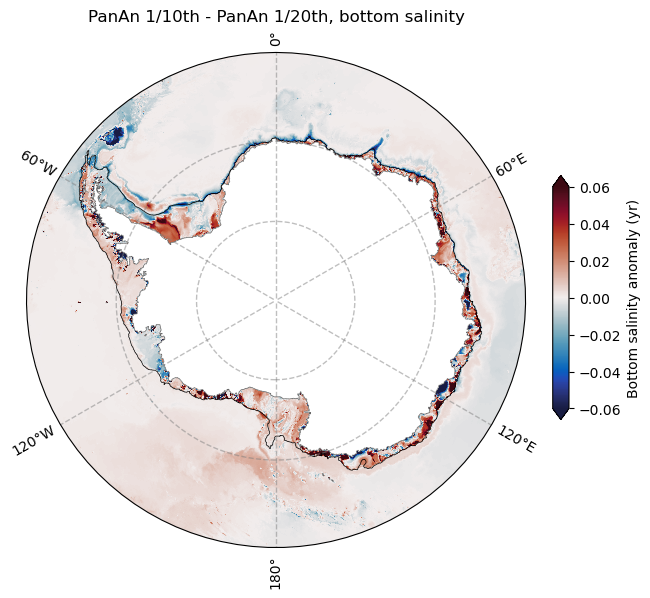

In [37]:
projection = ccrs.SouthPolarStereo()
    
plt.figure(figsize=(7, 8))
ax = plt.axes(projection=projection)
ax.set_extent([-280, 80, -80, -59], crs=ccrs.PlateCarree())
    
# Circular boundary
theta = np.linspace(0, 2 * np.pi, 100)
center, radius = [0.5,0.495], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

# Filled land 
land.plot.contourf(ax=ax, colors='white',
                   zorder=2,
                   transform=ccrs.PlateCarree(),
                   add_colorbar=False)

# Coast line
ax.contour(land_mask.cf['xh'], land_mask.cf['yh'], land_mask,
           levels = [0, 1], colors = 'dimgrey',linewidths=0.5, transform = ccrs.PlateCarree())
# Shelf contour
ax.contour(shelf_mask.cf['xh'], shelf_mask.cf['yh'], shelf_mask,
           levels = [0, 1], colors = 'k', linewidths=0.5,transform = ccrs.PlateCarree())

# Adding polar axes
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, 
                    xlocs=range(-180,171,60), ylocs=[], 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False, linewidth=1, 
                    xlocs=[], ylocs=(-80,-70,-55), 
                    color='gray', alpha=0.5, linestyle='--', zorder=10)

# Plotting
sob_anom_map.plot(
    x="xh",
    y="yh",
    transform=ccrs.PlateCarree(),
    vmin=-0.06,
    vmax=0.06,
    extend="both",
    cmap=cm.cm.balance, #cm ocean colour maps for more options, matplotlib has more also.
    cbar_kwargs={"label": "Bottom salinity anomaly (yr)", "fraction": 0.03, "aspect": 15, "shrink": 0.7},
);

plt.title("PanAn 1/10th - PanAn 1/20th, bottom salinity");